In [1]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [2]:
RS = 42

In [3]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 3:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state=RS, train_size=0.7)
X_test, X_ftest, Y_test, Y_ftest = train_test_split(X_test, Y_test, random_state=RS, train_size=0.7)
cnt_1 = Y_train[Y_train == 1].size
cnt_0 = Y_train[Y_train == 0].size
weight_for_1 = cnt_0 / cnt_1
weight_for_1

8.767661584711188

## 1. Влияние весов классов на метрики

In [4]:
params = {"max_depth": 5, "max_iter": 300, "learning_rate": 0.01}

draw_data = []
draw_data_f = []

for _weight_for_1 in [weight_for_1 * (i / 100) for i in range(20, 200, 5)]:
  class_weight = {0: 1, 1: _weight_for_1}

  clf = HistGradientBoostingClassifier(**params, class_weight=class_weight)
  clf.fit(X_train, Y_train)
  draw_data.append(metrics(clf.predict(X_test), Y_test, output=False))
  draw_data_f.append(metrics(clf.predict(X_ftest), Y_ftest, output=False))
  draw_data[-1]["weight"] = _weight_for_1
  draw_data_f[-1]["weight"] = _weight_for_1

KeyboardInterrupt: 

Best weight for F1 score: 3.9454477131200347. 
Best F1 score: 0.5831202046035806


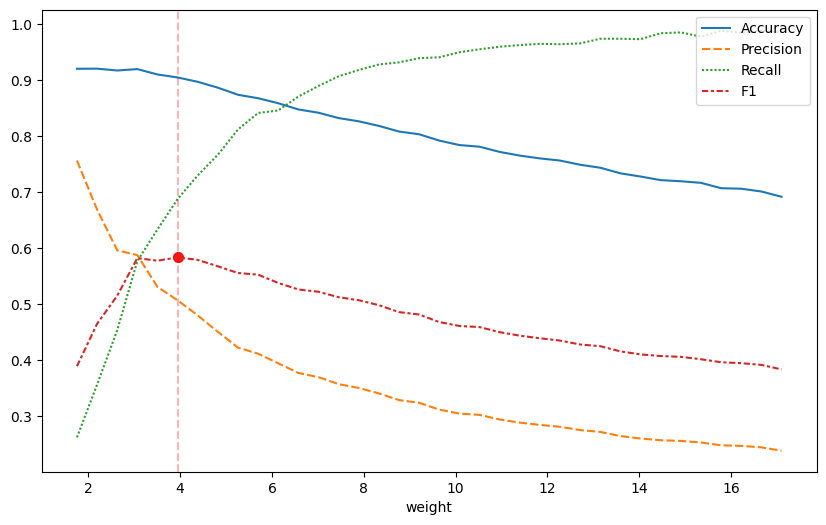

Best weight for F1 score: 3.9454477131200347. 
Best F1 score: 0.601568068424804


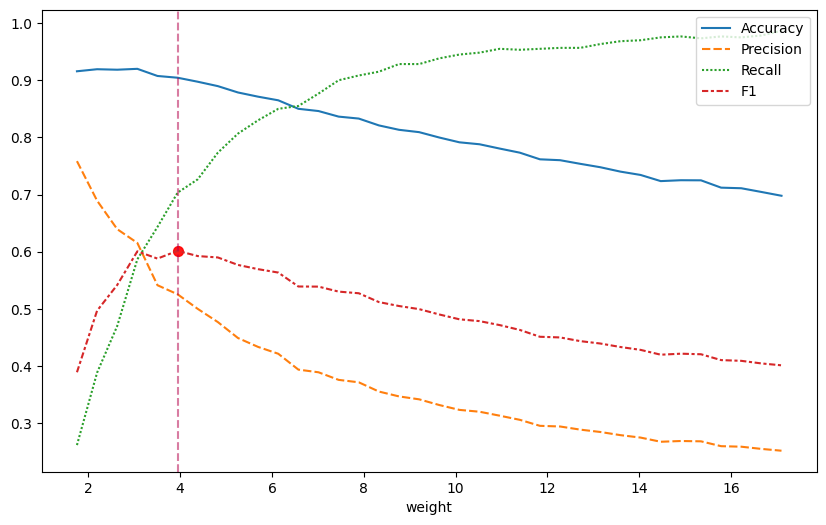

(np.float64(3.9454477131200347), np.float64(0.601568068424804))

In [5]:
def draw(draw_data, param_name:str, axvlines=[]):
  draw_df = pd.DataFrame(draw_data)
  draw_df = draw_df.set_index([param_name])

  best_weight_f1 = draw_df["F1"].idxmax()
  best_f1 = draw_df["F1"].max()

  print(f"Best {param_name} for F1 score: {best_weight_f1}. \nBest F1 score: {best_f1}")

  plt.figure(figsize=(10, 6))
  ax = sns.lineplot(data=draw_df)

  plt.legend(loc="upper right")

  # Highlight the best point
  ax.axvline(x=best_weight_f1, color='red', linestyle='--', alpha=0.3)
  ax.scatter(x=best_weight_f1, y=best_f1, color='red', s=50, alpha=0.9)
  for line in axvlines:
    ax.axvline(x=line, color='purple', linestyle='--', alpha=0.3)

  plt.show()

  return (best_weight_f1, best_f1)
  
best_weight_f1, best_f1 = draw(draw_data, "weight")
draw(draw_data_f, "weight", axvlines=[best_weight_f1])

#### Видно, что веса довольно сильно влияют

## 2. Влияние разбиения датасета на метрики

In [6]:
params = {"max_depth": 5, "max_iter": 300, "learning_rate": 0.01}

draw_data = []

N = Y_train[Y_train == 1].size  # number of variable stars
new_train = pd.concat([X_train, Y_train], axis=1)

print(new_train.head())

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])

  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = HistGradientBoostingClassifier(**params)
  clf.fit(X, Y)
  
  draw_data.append(metrics(clf.predict(X_test), Y_test, output=False))
  draw_data[-1]["ratio"] = r

       e_Vmag    Bmag  e_Bmag   gpmag  e_gpmag   rpmag  e_rpmag   ipmag  \
2016    0.011  11.141   0.014  10.827    0.015  10.342    0.013  10.482   
9867    0.065  15.720   0.017  15.477    0.023  15.172    0.062  15.240   
55781   0.006  13.810   0.017  13.470    0.014  13.101    0.023  12.831   
6861    0.167  16.145   0.152  15.682    0.132  15.188    0.137  15.022   
28122   0.033  11.918   0.000  11.693    0.036  11.588    0.043  11.618   

       e_ipmag  fuv_mag  nuv_mag       err  min_mag  max_mag  present  
2016     0.588   23.424   16.038  0.588604    13.32    13.36        0  
9867     0.226   23.113   17.997  0.244873    10.78     0.11        0  
55781    0.063   21.916   18.098  0.070845    12.02    12.04        0  
6861     0.037   23.508   21.893  0.297582    14.57     0.18        0  
28122    0.123   18.359   14.438  0.139151     9.80     0.17        0  


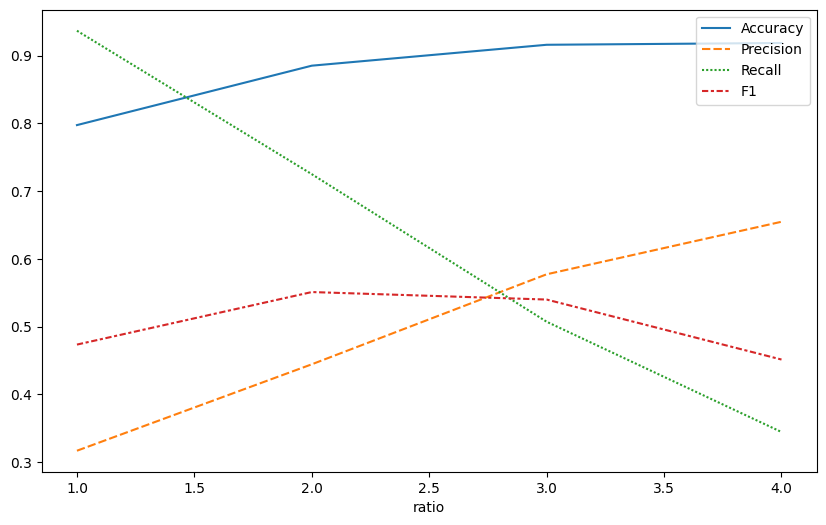

In [7]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["ratio"])
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")

plt.show()

## 3. Лучший Learning rate

In [8]:

weight_for_1 = best_weight_f1

class_weight = {0: 1, 1: weight_for_1}

params = {"max_depth": 5, "max_iter": 300, "class_weight": class_weight}

draw_data = []

for lr in [i / 1000 for i in range(1, 1000, 10)]:
  clf = HistGradientBoostingClassifier(**params, learning_rate=lr)

  clf.fit(X_train, Y_train)

  pred = clf.predict(X_test)

  metrics(pred, Y_test, output=False)
  
  draw_data.append(metrics(pred, Y_test, output=False))
  draw_data[-1]["Learning rate"] = lr

KeyboardInterrupt: 

Best learning rate for F1 score: 0.241
Best F1 score: 0.7423


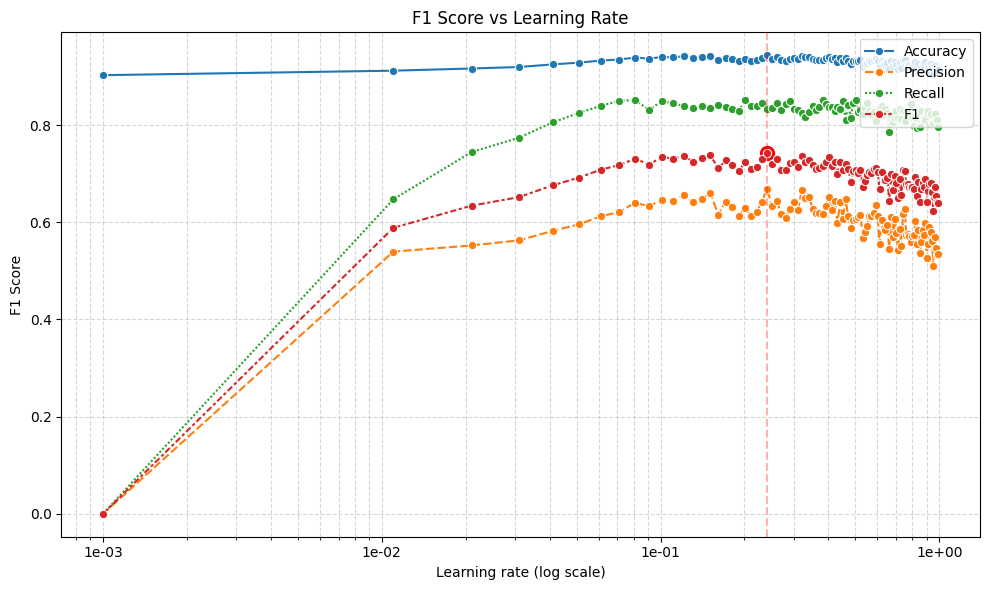

In [31]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index("Learning rate")

# Find best learning rate
best_lr = draw_df['F1'].idxmax()
best_f1 = draw_df['F1'].max()

print(f"Best learning rate for F1 score: {best_lr}\nBest F1 score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df, marker='o')

ax.set_xscale('log')
ax.set_xlabel('Learning rate (log scale)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score vs Learning Rate')

ax.axvline(x=best_lr, color='red', linestyle='--', alpha=0.3)
ax.scatter(x=best_lr, y=best_f1, color='red', s=100)

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Improve tick formatting
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Пример с работы модели с настроенными параметрами

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11845
           1       0.85      0.62      0.72      1802

    accuracy                           0.94     13647
   macro avg       0.90      0.80      0.84     13647
weighted avg       0.93      0.94      0.93     13647



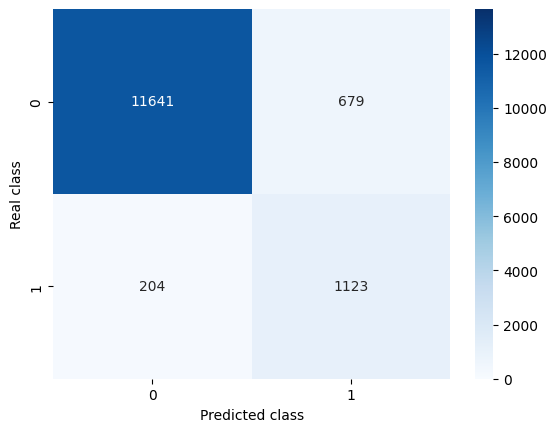

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5058
           1       0.85      0.65      0.73       791

    accuracy                           0.94      5849
   macro avg       0.90      0.81      0.85      5849
weighted avg       0.93      0.94      0.93      5849



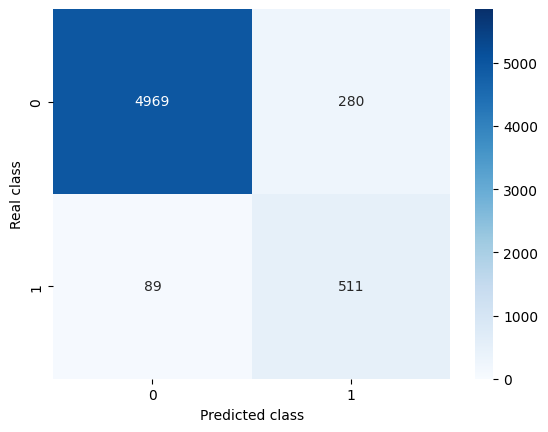

{'Accuracy': 0.9369122926996067,
 'Precision': 0.6460176991150443,
 'Recall': 0.8516666666666667,
 'F1': 0.7347232207045291}

In [33]:
params = {"max_iter": 300, "max_depth": 5, "learning_rate": best_lr, "class_weight": {0: 1, 1:best_weight_f1}}

clf = HistGradientBoostingClassifier(**params)

clf.fit(X_train, Y_train)

pred = clf.predict(X_test)

metrics(pred, Y_test, False)

pred = clf.predict(X_ftest)

metrics(pred, Y_ftest)